# process spectra for AuxTel with new spectractor (September 2021)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 14th 2021
- last update : November 2nd 2021
- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

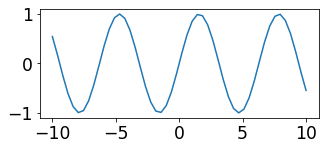

In [2]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [3]:
from iminuit import Minuit
import iminuit

In [4]:
iminuit.__version__

'2.7.0'

In [5]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [6]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [7]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

In [8]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [9]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [10]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [11]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [12]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [13]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [14]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [15]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_' + version+'.csv'

In [16]:
df=pd.read_csv(filename_logbook,index_col=0)

In [17]:
pd.set_option('display.max_rows', None)

In [18]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2000.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2000.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [19]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [20]:
#idx=76
#idx=96
#idx=76 # start of narrow scan

# Wide scan

#idx= 19  # outside
#idx=20 # outsie
#idx=21 # outside
#idx=22 # outside
#idx=23 # outside
#idx=24 # outside
#idx=25 # outside

#idx=26

#idx=30  # Must be eliminated
#idx=31  # BAD Calib WL, tronqué
#idx=32     # BAD Calib WL, tronqué
#idx=33      # BAD Calib WL, tronqué
#idx=34     # BAD calib WL, tronqué
#idx=35    # OK mais tronqué
#idx=36   # OK mais tronqué
#idx=37   # CRASH
#idx=38    # GOOD
#idx=39        # GOOD
#idx=40       # GOOD
#idx=41      # CRASH
#idx=42     # BAD, BAD STAR
#idx=43     # OUT
#idx=44     # OK
#idx=45    # OK
#idx= 46  # OK
#idx= 47   # crash
#idx=48   # OK
#idx=49   # NON OUT
#idx=50   # OK
#idx=51   # OK
#idx=52   # OK
#idx=53   # OK
#idx=54   # OK
#idx=55   # OK
#idx=56   # OK
#idx=57   # OK
#idx=58   # OUT
#idx=59    # OUT
#idx=60  # OUT
#idx=61  # CRASH
#idx=62  # OK good
#idx=63  # OK good
#idx=64 # OK Good
#idx=65  # OUT
#idx=66 # OUT
#idx=67  # OUT
#idx=68  # BORDER CRASH
#idx= 69  # OK Good
#idx=70 # OK GOOD
#idx=71 # OK GOOD
#idx=72 # RG610

#idx=75 # OUT

#--------

# narrow scan

idx=76

#idx=111 # failed too close from border
#idx=112 # failed too close from border
#idx=113 # failed too close from border
#idx=114 # failed too close from border
#idx=115 # failed too close from border
#idx=116 # failed too close from border
#idx=117 # failed too close from border
#idx=118 # failed too close from border
#idx=119 # failed too close from border
#idx=120 # failed too close from border
#idx=121 # failed too close from border
#idx=122 # failed too close from border
#idx=123 # failed too close from border

In [21]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits


In [22]:
print(df.iloc[idx])

index                                                         76
date                                     2021-07-08T04:49:32.013
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000317_quick...
num                                                          317
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.065945
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.3
humidity                                                     6.0
windspd                  

In [23]:
myhome=os.getenv("HOME")

In [24]:
dir_images=path_images

In [25]:
dir_images

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07'

In [26]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [27]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [28]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [29]:
FLAG_ORDER0_LOCATION=False

In [30]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (500.0,1900.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [31]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000317_quickLookExp'

In [32]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [33]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [34]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp'

### manage output dir

In [35]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [36]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [37]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [38]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [39]:
parameters.OBS_NAME

'AUXTEL'

In [40]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [41]:
parameters.DISTANCE2CCD

182.0

In [42]:
parameters.LAMBDA_MIN 

300

In [43]:
parameters.LAMBDA_MAX 

1100

In [44]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [45]:
image.filter_label

''

In [46]:
image.header["FILTER"]

'empty_1'

In [47]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

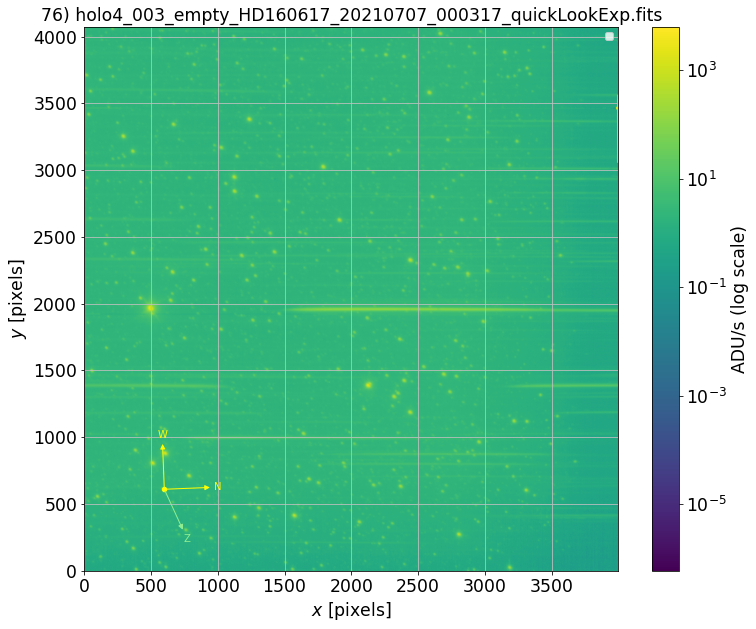

In [48]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [49]:
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [50]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (500.0,1900.0)


## Let Spectractor find the location of the 0th order

2021-11-08 10:00:56  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                  c1_0                  c0_1        
    ------------------ ----------------------- --------------------
    2.2481632938193115 -0.00024012120497443897 0.016983620730871615
2021-11-08 10:00:57  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 16 iterations because the relative change of cost is below ftol=1.25e-05.


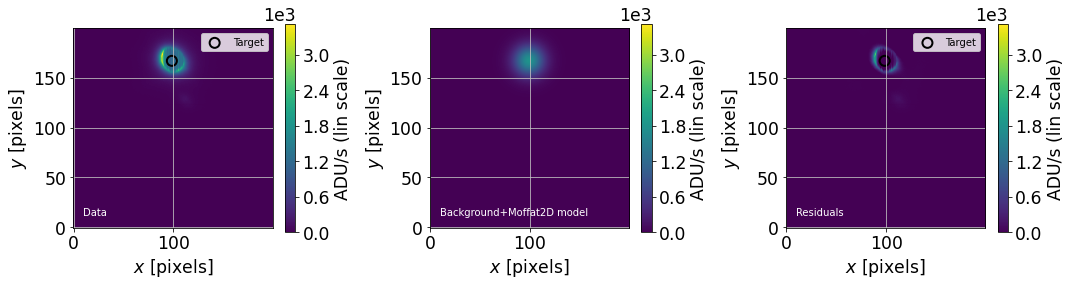

2021-11-08 10:00:58  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 6 iterations because the relative change of cost is below ftol=6.0240963855421684e-05.


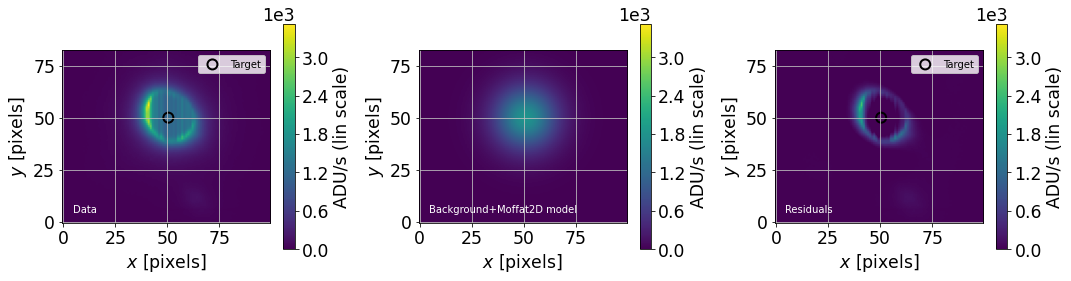

In [51]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [52]:
print(x1,y1)

498.5028269626463 1967.0212203987867


## Check the location of 0th order and Analysis of the quality of its focus

In [53]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [54]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [55]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [56]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [57]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [58]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [59]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [60]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [61]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [62]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [63]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [64]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [65]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-66-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '76) holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits')

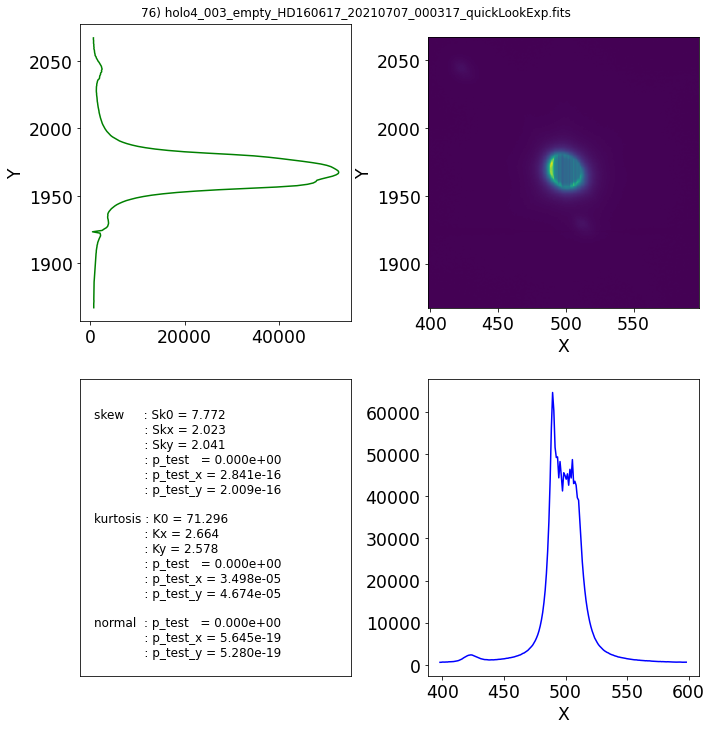

In [66]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [67]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [68]:
#parameters.debug=True
#parameters.verbose=True
#parameters.display=True
#parameters.LIVE_FIT=False

In [69]:
parameters.debug=False
parameters.verbose=False
parameters.display=True
parameters.LIVE_FIT=False

In [70]:
filename

'/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

2021-11-08 10:00:59  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-11-08 10:00:59  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp_v2/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits...
2021-11-08 10:00:59  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-11-08 10:00:59  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-11-08 10:01:00  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-11-08 10:01:00  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-11-08 10:01:05  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
2021-11-08 10:01:05  Star       load_spectra         INFO   
	Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd160617_stis_001.fits
2021-11-08 10:01:05  Star       load_

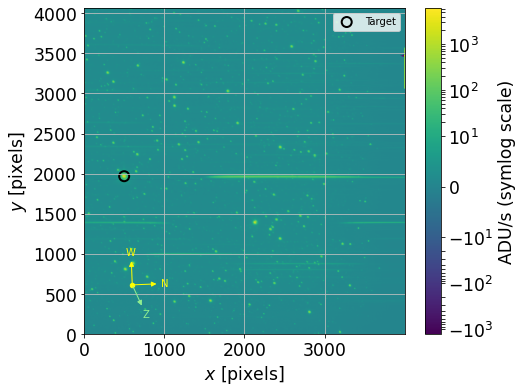

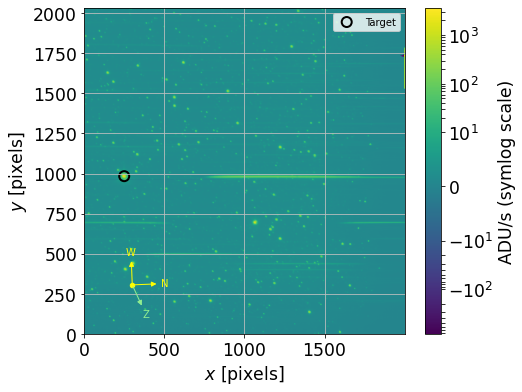

2021-11-08 10:01:12  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[249.25141348 983.5106102 ]...
2021-11-08 10:01:12  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                   c0_1        
    ----------------- ---------------------- ---------------------
    4.685079956054529 -0.0038929604566624865 0.0040437541306491305
2021-11-08 10:01:12  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 12 iterations because the relative change of cost is below ftol=5e-05.


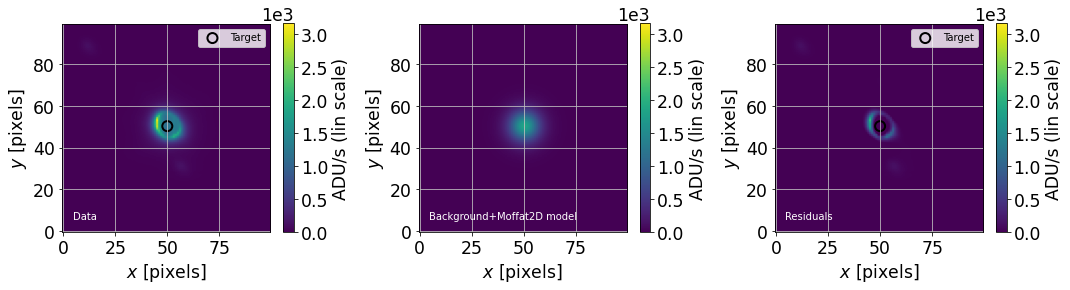

2021-11-08 10:01:13  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


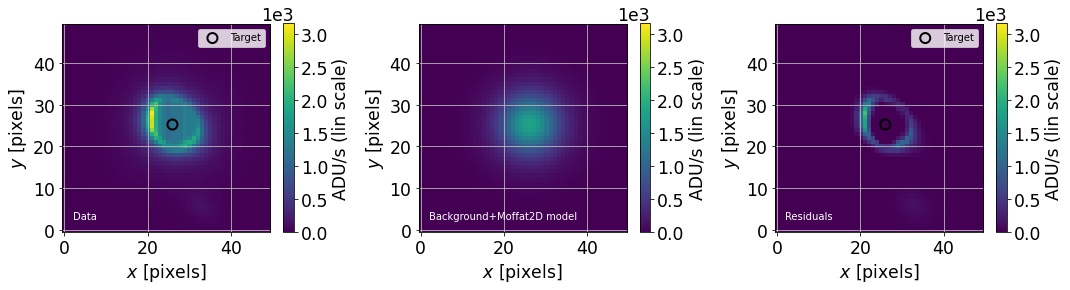

2021-11-08 10:01:14  Image      find_target          INFO   
	X,Y target position in pixels: 248.991,983.272
2021-11-08 10:01:14  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


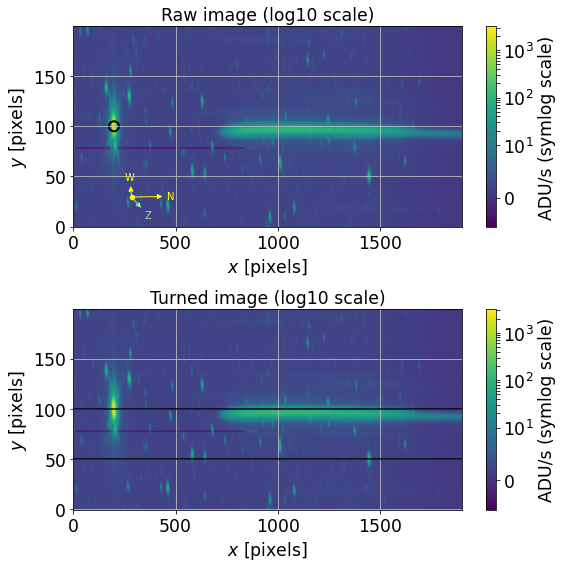

2021-11-08 10:01:19  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-11-08 10:01:19  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    15.961386682927468 0.17678001231302992 0.017156022003925145
2021-11-08 10:01:19  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 9 iterations because the relative change of cost is below ftol=0.0002.


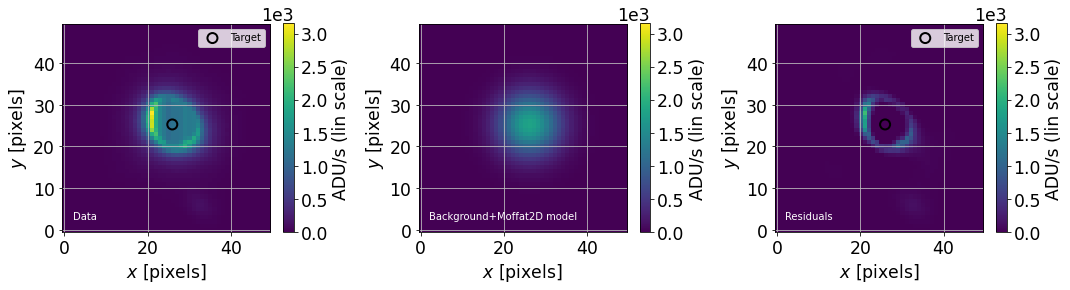

2021-11-08 10:01:20  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


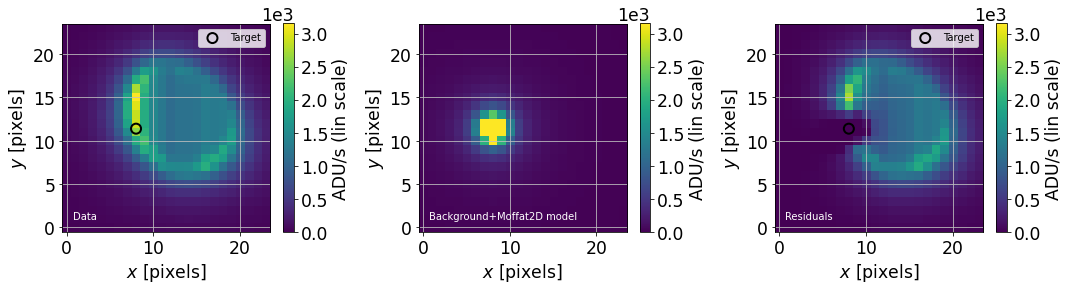

2021-11-08 10:01:21  Image      find_target          INFO   
	X,Y target position in pixels: 244.015,982.392
2021-11-08 10:01:21  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-11-08 10:01:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-11-08 10:01:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [670:1828,892:1072] (size (1158, 180))


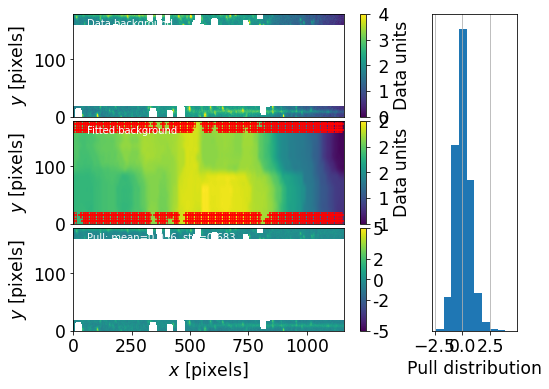

2021-11-08 10:01:23  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


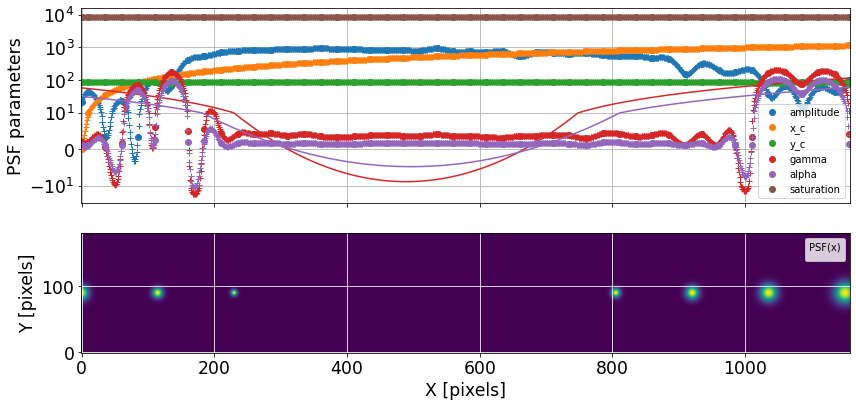

2021-11-08 10:01:28  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.8654e+05 initial chisq_red=4.0273
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.20007541 -0.25274913 -0.51779322 -1.80504126 -1.83515921 -4.5716062
 -1.14456403 -1.1347674  -2.81303891]
	New parameters: [-3.94766791 -1.01070879 -2.22058373  4.46189061 -0.2155178   2.06802401
  1.6572286  -0.23162134  0.3669056 ]
	Final cost=1.4016e+05 final chisq_red=3.0259 computed in 0.58s
2021-11-08 10:01:28  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4016e+05 initial chisq_red=3.0259
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.01364173  0.01888483  0.03238782 -0.09039377  0.02967964 -0.56307591
  0.08318926  0.13163829 -0.04321298]
	New parameters: [-3.93402619 -0.99182397 -2.18819591  4.37149683 -0.18583816  1.5049481
  1.74041786 -0.09998305  0.32369262]
	Final cost=1.2328e+05 final chisq_red=2.6616 computed in 

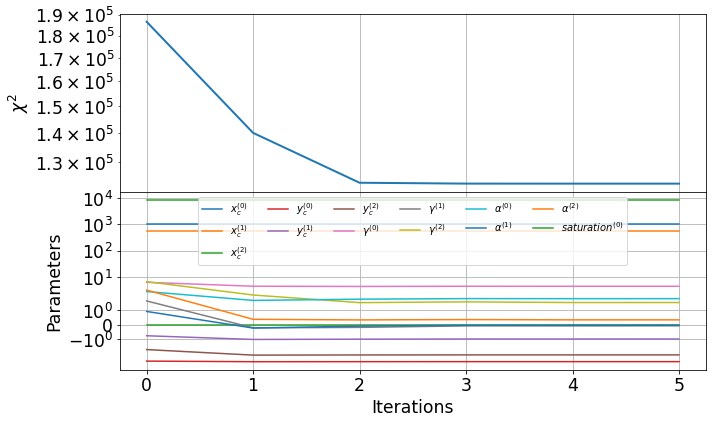

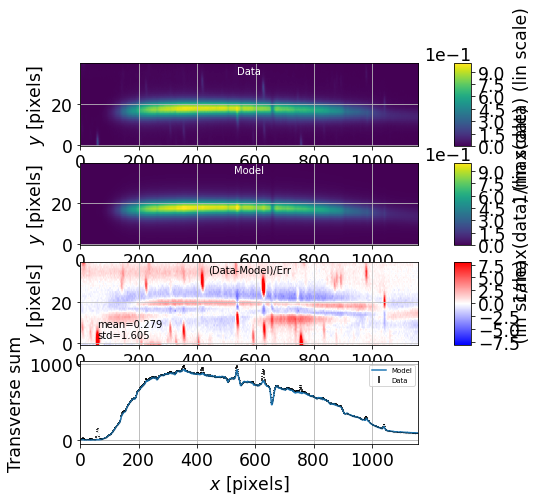

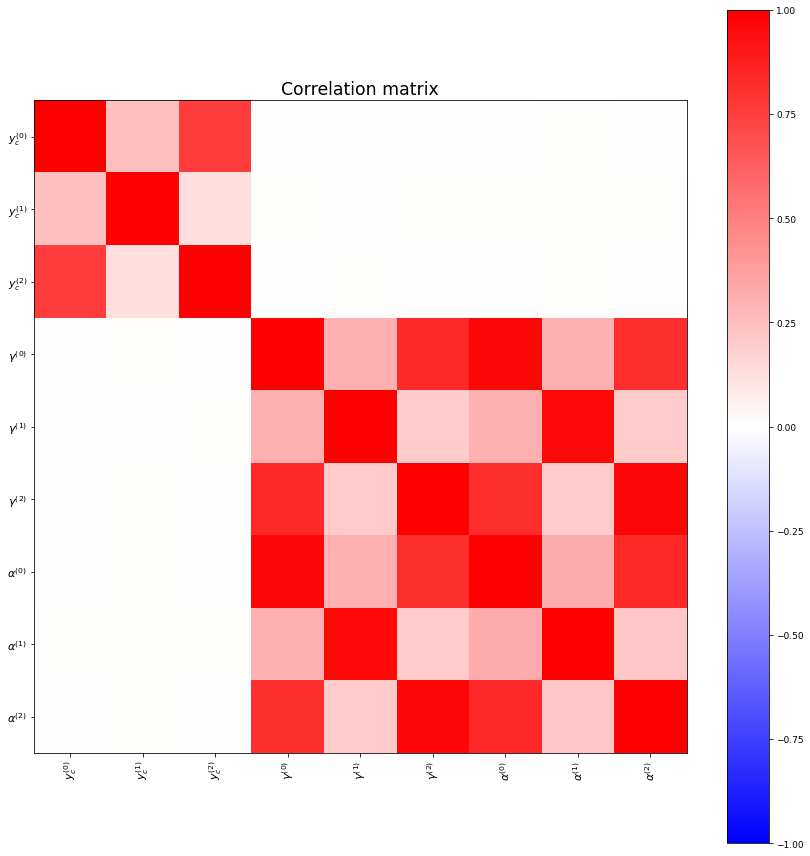

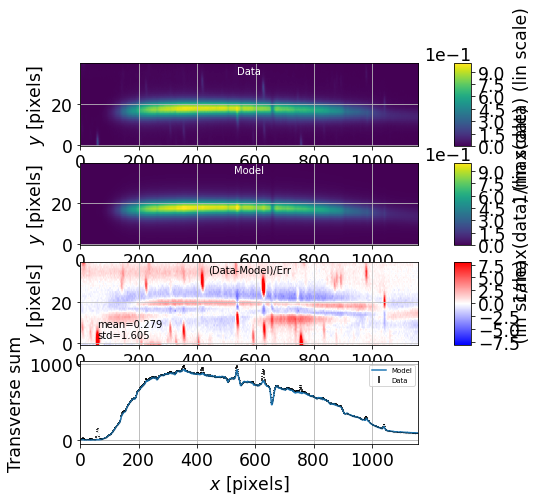

2021-11-08 10:01:37  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c          y_c        ...          Dy         Dy_disp_axis
------------------ ------ ----------------- ... ------------------- ------------
7.3996047024620655    0.0  85.2713231121397 ...  -5.120497497770685          0.0
 6.530914077458897    1.0 85.28089251579065 ...  -5.110928094119728          0.0
 6.928448927514624    2.0 85.29044242848896 ...  -5.101378181421424          0.0
 3.562462768858877    3.0 85.29997285023461 ... -5.0918477596757725          0.0
 6.494559547773954    4.0  85.3094837810276 ...  -5.082336828882788          0.0
 5.195357043595985    5.0 85.31897522086793 ...  -5.072845389042456          0.0
 5.317770500574882    6.0 85.32844716975559 ...  -5.063373440154791          0.0
 7.373148444055736    7.0  85.3378996276906 ...  -5.053920982219779          0.0
 6.509182818445671    8.0 85.34733259467296 ...   -5.0444880

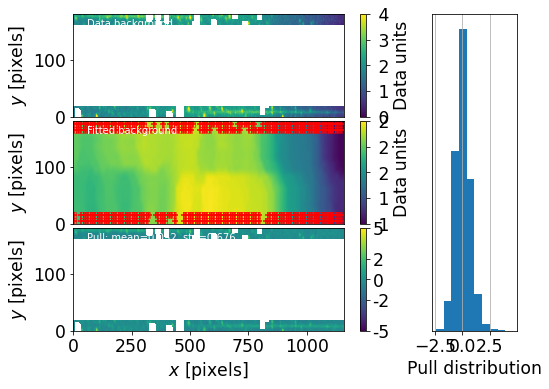

2021-11-08 10:01:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.000 ADU/s, RMS=0.282 ADU/s.
2021-11-08 10:01:39  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [673:1831,893:1074] (size (1158, 181))
	New target position in spectrogram frame: [-424.009060178769, 90.27184590925094]


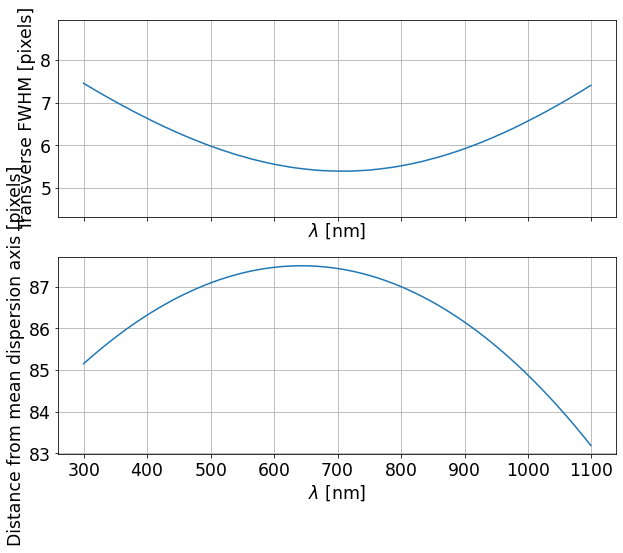

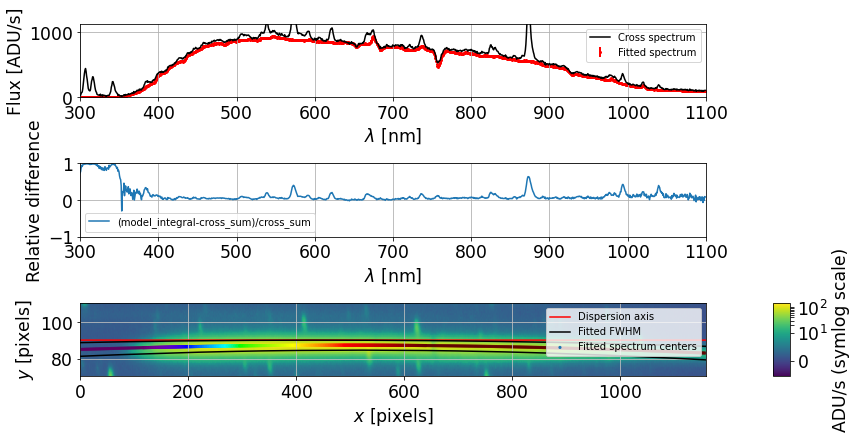

2021-11-08 10:01:41  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


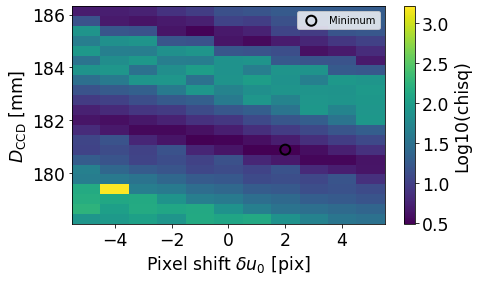

2021-11-08 10:02:04  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 1.590pix
	D = 180.878 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -1.5 sigma shift)
2021-11-08 10:02:06  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-11-08 10:02:22  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.109e+06 initial chisq_red=146.24
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.08732555 -0.11439282]
	New parameters: [-1.08732555 -0.11439282]
	Final cost=1.3639e+06 final chisq_red=32.649 computed in 13.33s
2021-11-08 10:02:37  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.3639e+06 initial chisq_red=32.649
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.07225703 -0.07169995]
	New parameters: [-1.01506852 -0.18609276]
	Final cost=8.8659e+05 final chisq_red=21.223 computed in 14.39s
2021-11-08 10:02:52

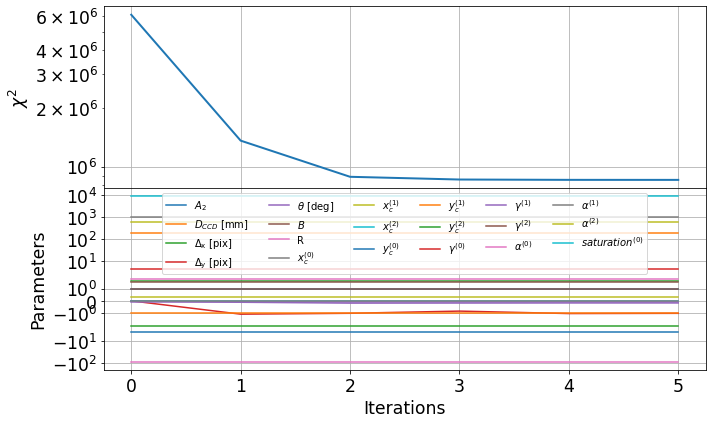

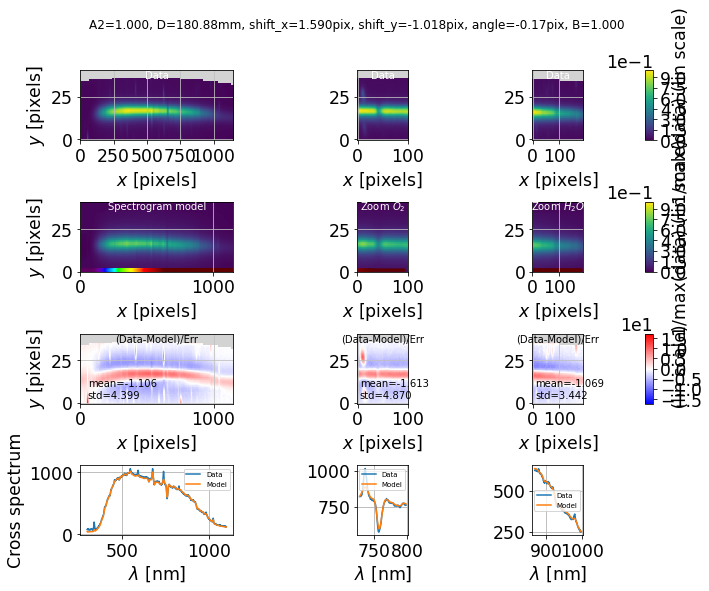

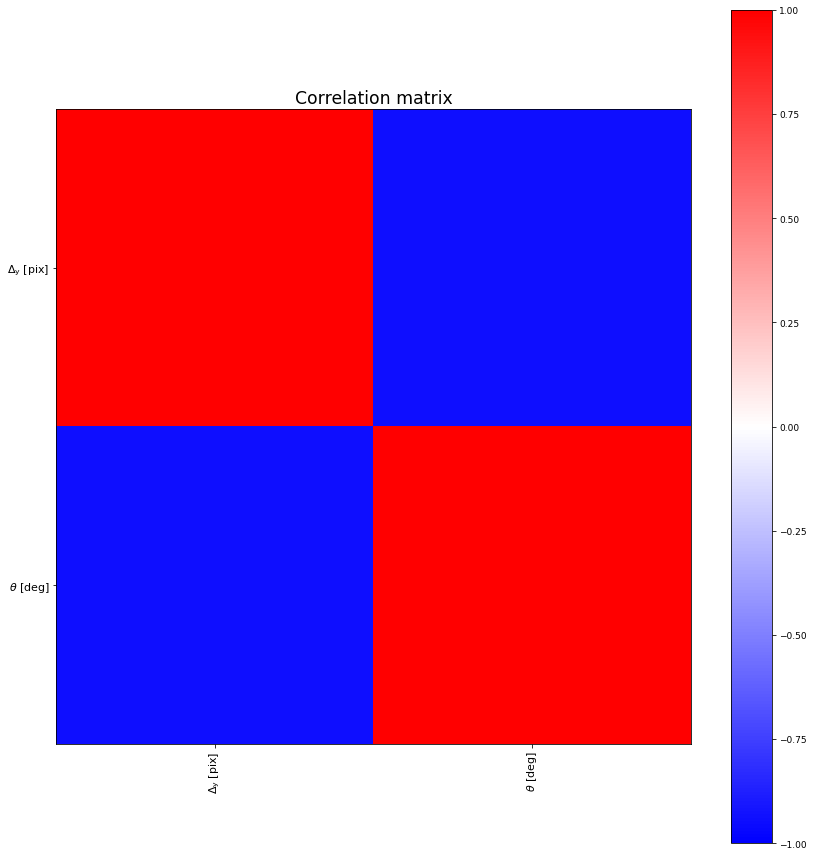

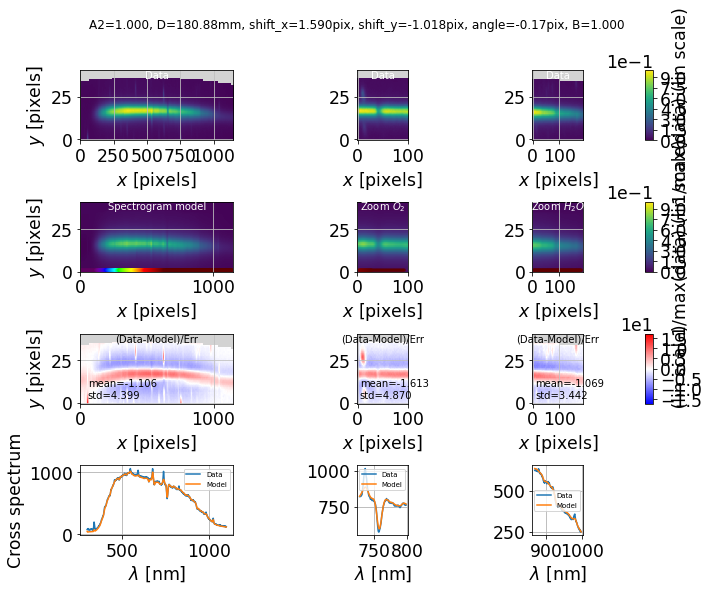

2021-11-08 10:03:29  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80878333e+02  1.59010540e+00 -1.01829086e+00
 -1.72447608e-01  1.00000000e+00 -8.77528175e+01  1.00448493e+03
  5.78500000e+02  2.53478364e-13 -3.92755044e+00 -9.81348301e-01
 -2.17429536e+00  4.43738037e+00 -7.87404437e-02  1.51258766e+00
  1.77738062e+00 -3.59193601e-02  3.28930155e-01  8.50000000e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-11-08 10:03:53  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=8.5463e+05 initial chisq_red=20.458
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.08030427  0.0079019  -1.10771353 -0.17494571  0.01234727  0.1141393
 -0.0068687   0.03641992]
	New parameters: [-1.09859512 -0.16454571  3.32966684 -0.

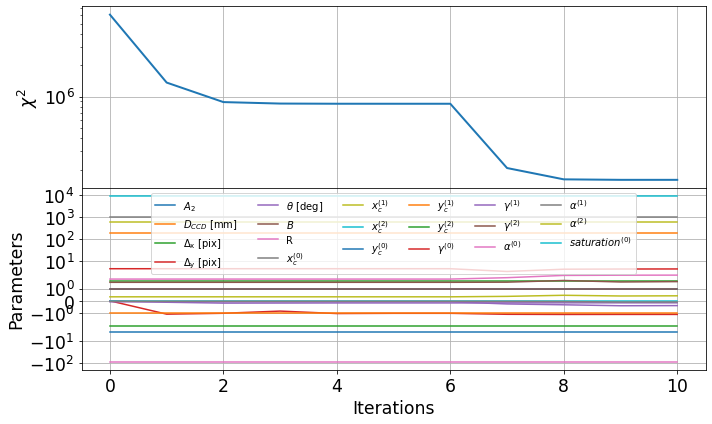

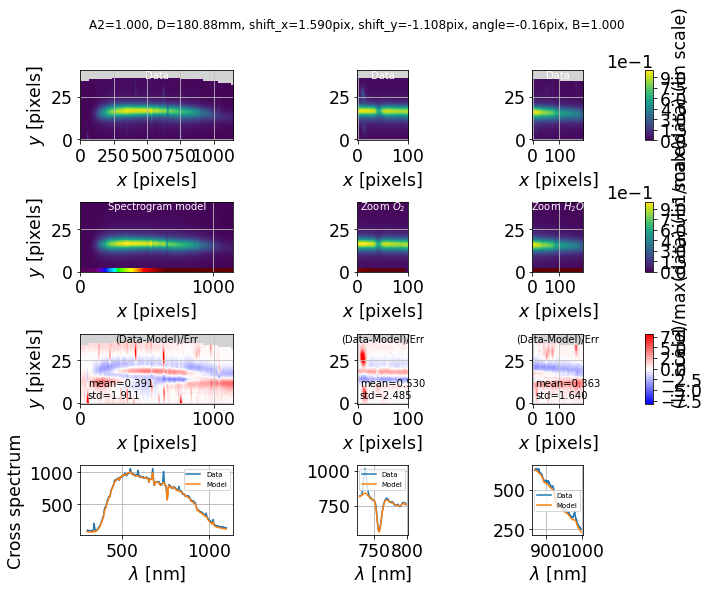

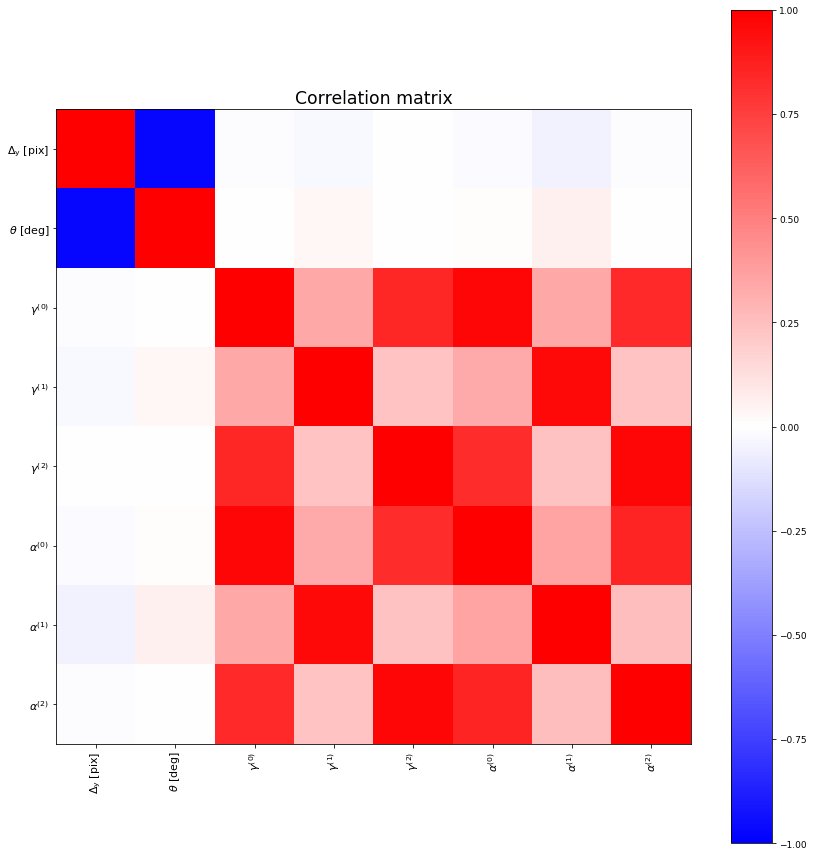

2021-11-08 10:05:07  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
2021-11-08 10:05:20  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[-0.342375 ],
       [-0.3423125]]), array([4.25373101e-09, 4.25373101e-09]))
           fun: 4.253731008550558e-09
       message: 'Optimization terminated successfully.'
          nfev: 44
           nit: 22
        status: 0
       success: True
             x: array([-0.342375])
2021-11-08 10:05:20  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 12.331141233444214s


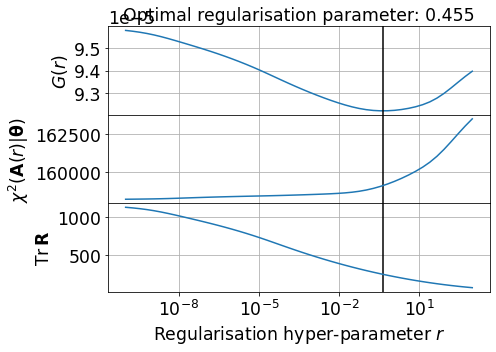

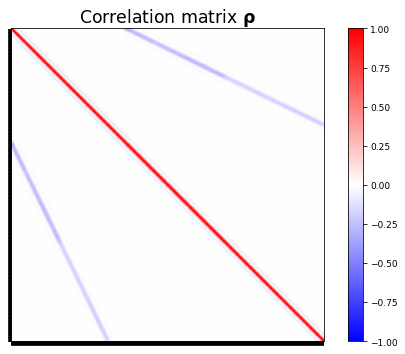

2021-11-08 10:05:49  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.45459536144431023
	Tr(R) = 241.23850675203278
	N_params = 1158
	N_data = 41775 (without mask and outliers)
2021-11-08 10:06:14  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5919e+05 initial chisq_red=3.8142
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 1.69835549e-04 -2.45168041e-05 -2.71614797e-04 -1.07982218e-03
  1.17647544e-02 -1.14823079e-03 -1.09132816e-03  7.25649907e-03]
	New parameters: [-1.10793125 -0.16231398  4.32890008 -0.38984536  1.58164564  2.27202214
 -0.09401143  0.4185697 ]
	Final cost=1.5919e+05 final chisq_red=3.814 computed in 19.29s
2021-11-08 10:06:36  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5919e+05 initial chisq_red=3.814
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ 5.23917714e-04 -3.36397577e-05 -6.82224286e-04 -7.76072283e-04
 

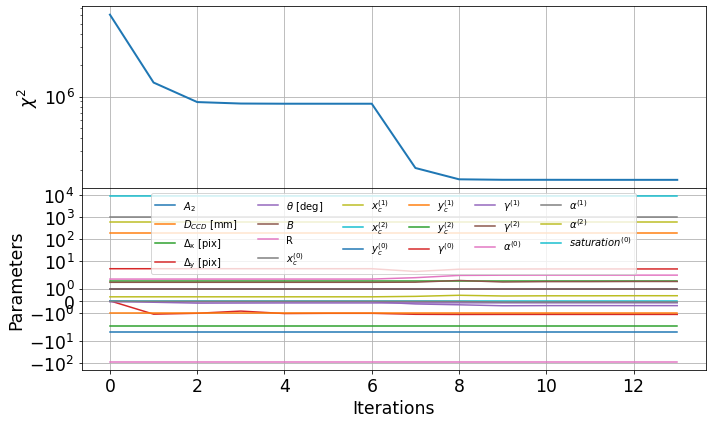

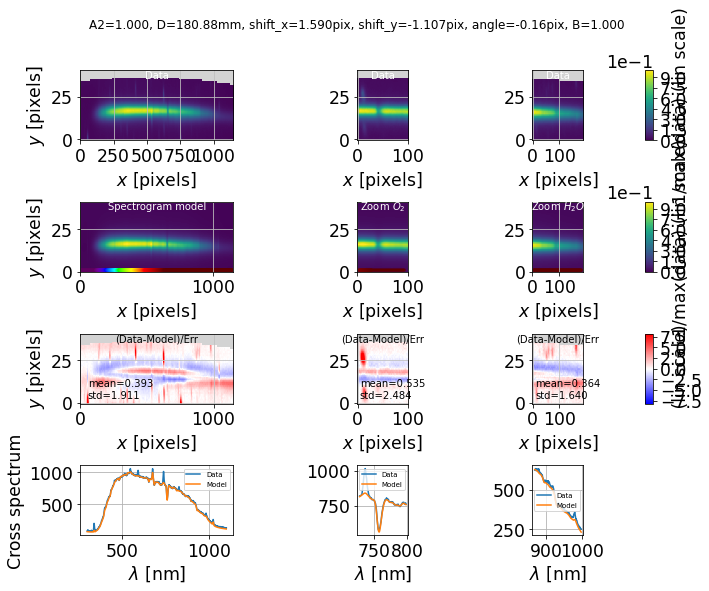

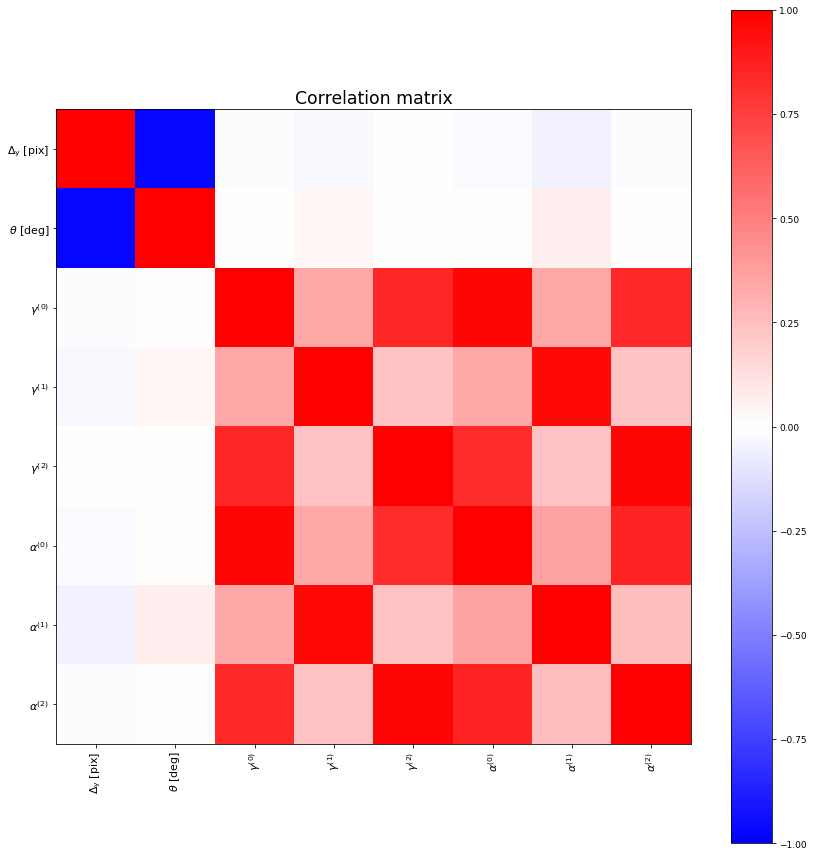

2021-11-08 10:06:42  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-11-08 10:06:42  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-11-08 10:07:07  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5461e+05 initial chisq_red=3.7043
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ 3.56638357e-04 -2.36652000e-05 -5.55786424e-04 -3.37826423e-03
 -2.44542375e-04 -2.69382402e-04 -1.60098611e-03 -9.63355284e-05]
	New parameters: [-1.1070507  -0.16237128  4.32766207 -0.3939997   1.58039269  2.27141611
 -0.09602937  0.41800129]
	Final cost=1.5461e+05 final chisq_red=3.7043 computed in 22.82s
2021-11-08 10:07:27  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5461e+05 initial chisq_red=3.7043
		 Line search: alpha

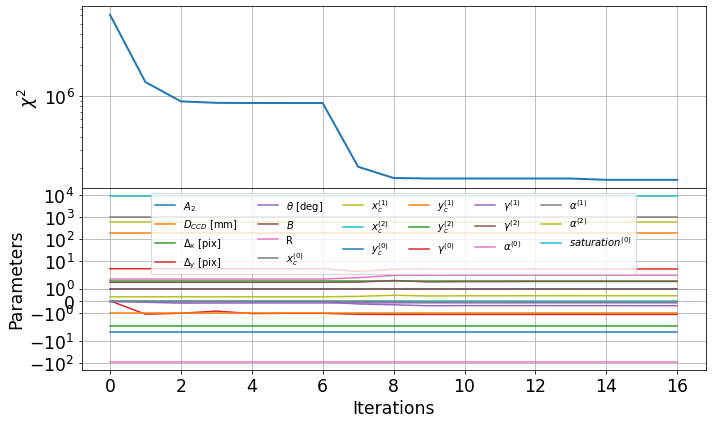

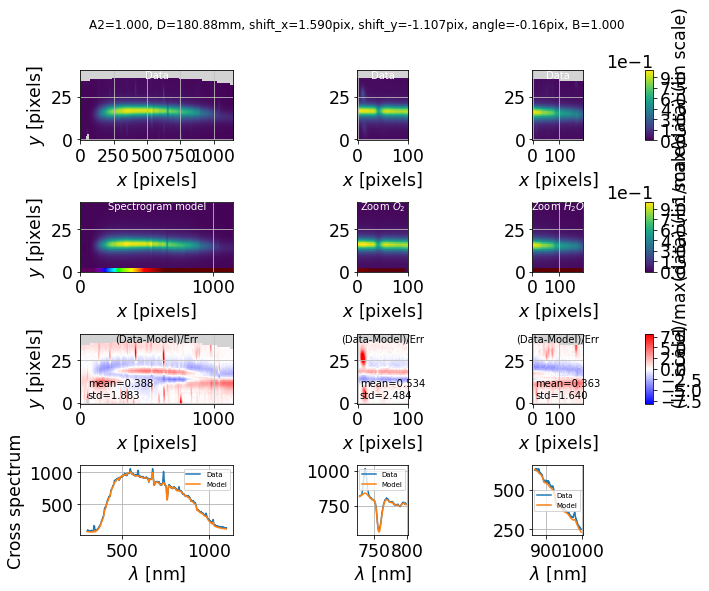

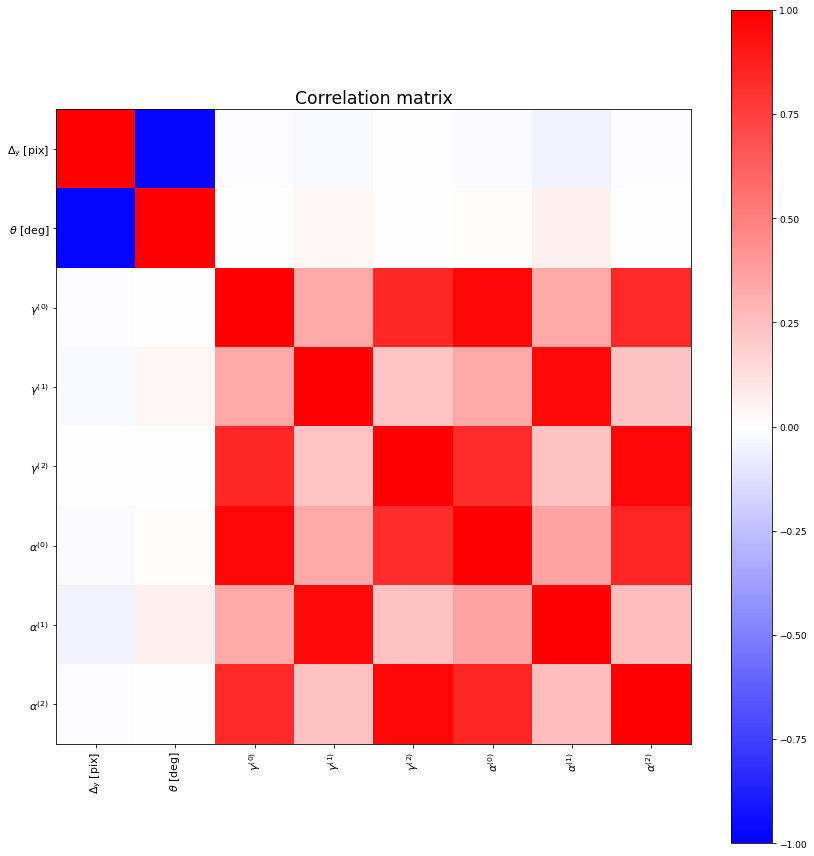

2021-11-08 10:07:32  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-11-08 10:07:32  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-11-08 10:07:32  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-11-08 10:07:32  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 242.77346205711365s


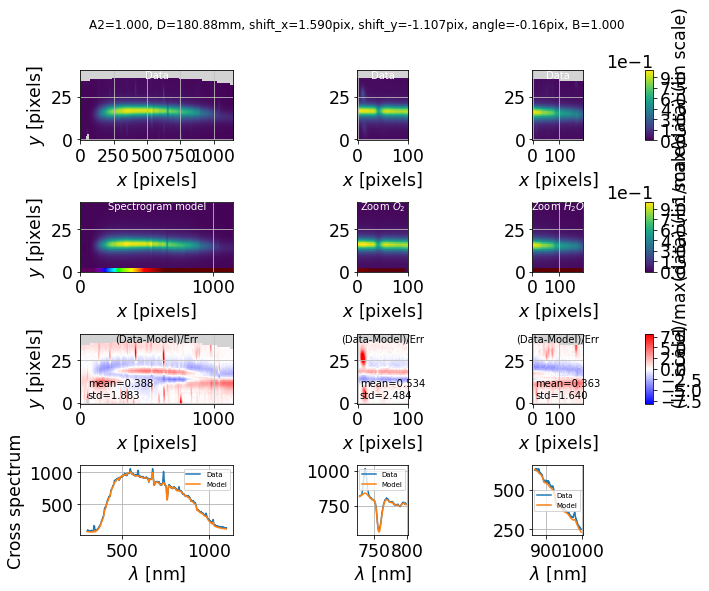

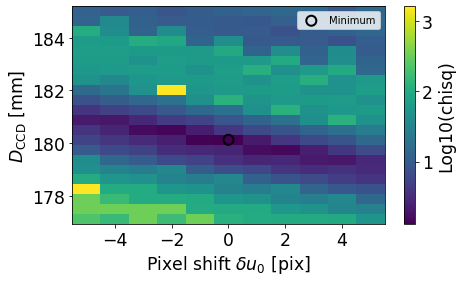

2021-11-08 10:07:48  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.293pix
	D = 180.076 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.6 sigma shift)
2021-11-08 10:08:14  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5756e+05 initial chisq_red=3.775
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.02546231  0.00046914 -0.00191502  0.01951053 -0.01905742 -0.00370286
  0.00566099 -0.01284505]
	New parameters: [-1.13281    -0.16188289  4.32570085 -0.37468062  1.5608526   2.26767018
 -0.09048969  0.40483588]
	Final cost=1.5728e+05 final chisq_red=3.7684 computed in 22.10s
2021-11-08 10:08:34  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5728e+05 initial chisq_red=3.7684
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.014173   -0.00088228  0.00749226  0.02028864 -0.00274454  0.00383265
  0.008799    0.00202224]
	New parameters: [-1.118637   -0.16276516  4.3331

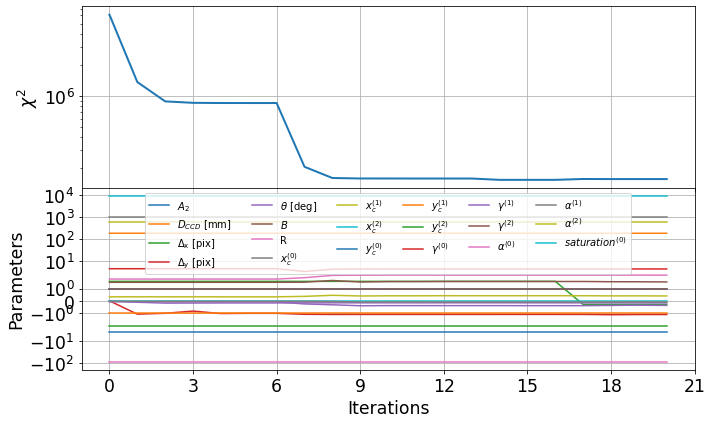

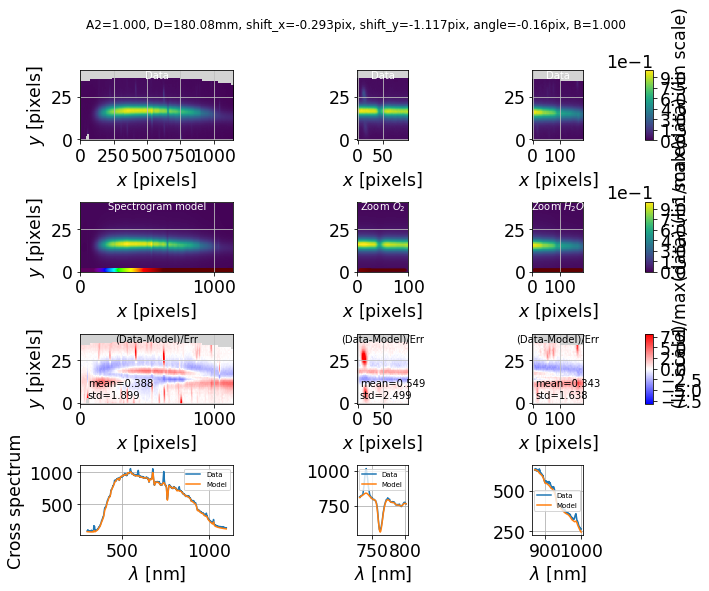

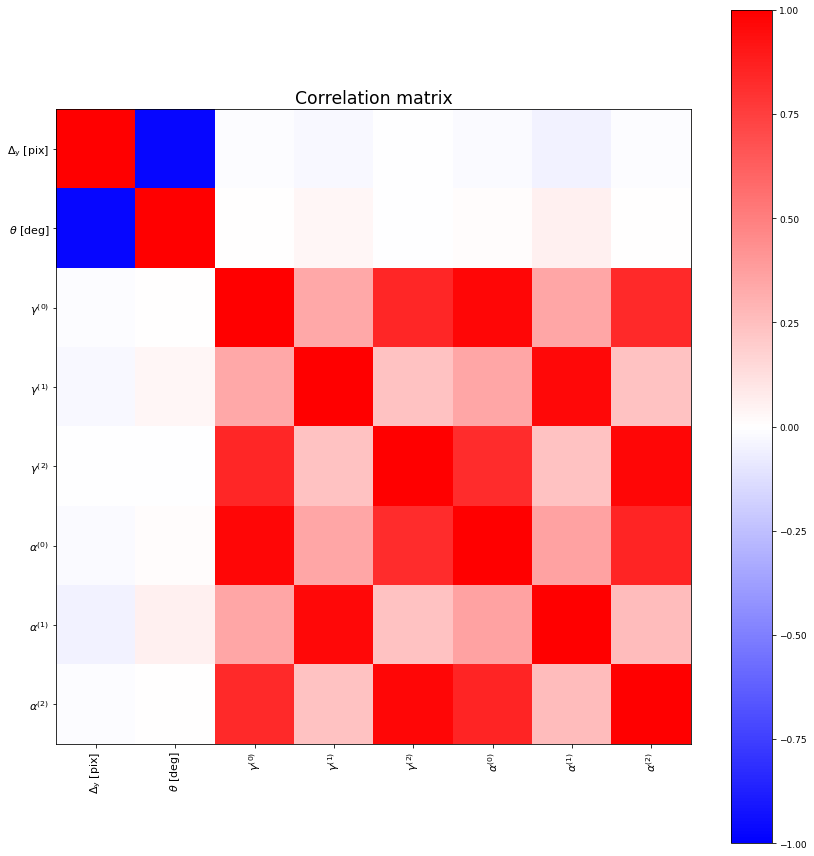

2021-11-08 10:08:59  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-11-08 10:08:59  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-11-08 10:08:59  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-11-08 10:08:59  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 330.3617012500763s


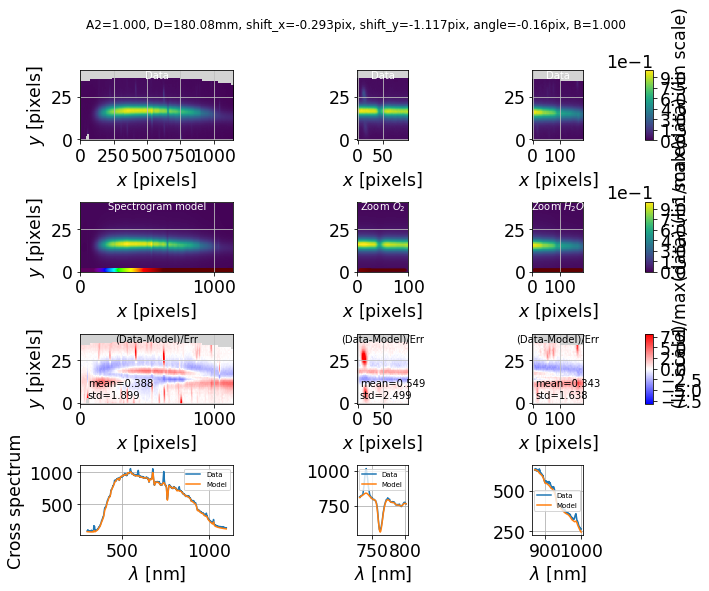

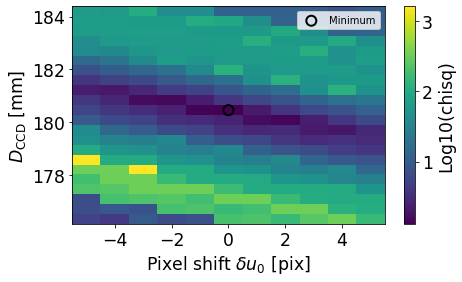

2021-11-08 10:09:20  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.168pix
	D = 180.382 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.2 sigma shift)
2021-11-08 10:09:21  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-11-08 10:09:21  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-11-08 10:09:21  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits
2021-11-08 10:09:22  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrogram.fits


    Line    Tabulated  Detected ...   Chisq    Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced        nm          nm     
----------- --------- --------- ... ---------- ----------- ------------
   $Fe_{I}$   382.172 377.96112 ...  1.0958825   4.3703117     21.64536
  $Ca_{II}$ 393.49777 388.84573 ...  1.0958825    1.926564      8.34723
  $Ca_{II}$ 396.97995 395.35532 ...  1.0958825   1.2660815    5.1459584
$H\epsilon$   397.133 401.71008 ...  1.0958825   1.2038207    11.597438
  $H\delta$  410.3374  409.4335 ...  1.0958825   1.3614293    5.9443417
   $Fe_{I}$ 430.93433 421.17606 ...  1.0958825    2.710549     9.659041
  $H\gamma$  434.1454 432.80203 ...  1.0958825   2.0822532    6.1471667
   $Fe_{I}$ 438.50186 442.42102 ...  1.0958825  0.86054903     4.994241
   $He_{I}$  447.2498 450.50995 ...  1.0958825   1.6451125     3.452302
   $H\beta$ 486.46292 485.46072 ...  0.4622111  0.34316152   0.28076774
   $Fe_{I}$  527.2156 528.20087 ...  0.4622111  0.24245188   0.2

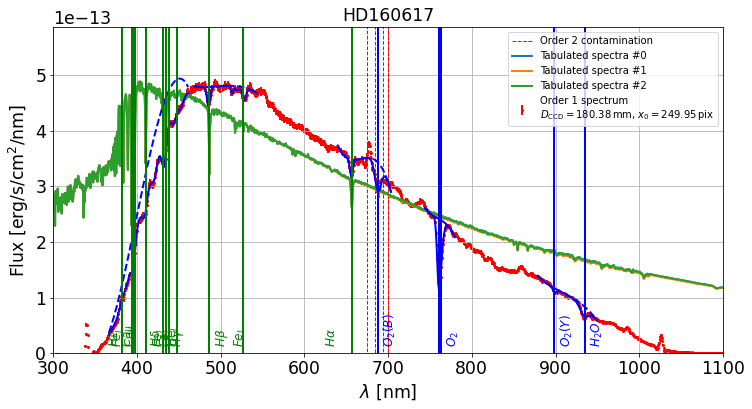

In [71]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [72]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_lines.csv']

In [73]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/